In [1]:
# python 3.7
# -*- coding: utf-8 -*-
# @Author  : Xueli
# Computing NDCG@10, P@10 and MRR 


import re
import pandas as pd
import numpy as np

def standarize(input_str):
    """
    e.g:
    change "/AAMAS/AAMAS2005/p1067-sukthankar.pdf\n" to "AAMAS05-p1067-sukthankar"
    :param input_str: the conference info and paperID of the items in top-10 rank list
    :return: paper ID that match the ground truth
    """
    result = re.split(r'/', input_str)
    paperInfo = result[-1].replace('.pdf\n','')
    if '20' in result[-2]:
        conInfo = result[-2].replace('20','')
    if '19' in result[-2]:
        conInfo = result[-2].replace('19','')
    item_name = conInfo + '-' + paperInfo
    return item_name

def rename_rank_item(data,num_user):
    """
    rename all items name in the ranking result so as to check if the item in 
    the result list hit the ground truth.
    :param data: a csv file that contain columns : ranking,R1,R2,R3...R50
    :param num_user: number of columns in csv file, in this case num_user=50
    : return ranking_df: the ranking dataframe with standard item name in each cell
    """
    ranking = pd.read_csv(data)
    ranking_df = pd.DataFrame()
    # n denotes number of researchers, k denote top-k ranking list
    for n in range(1,num_user+1,1):
        r = 'R' + str(n)
        ranking_ls = []
        for k in range(len(ranking[r])):
            input_str = ranking[r][k]
            ranking_item = standarize(input_str)
            ranking_ls.append(ranking_item)
        ranking_df[r] = ranking_ls
    return ranking_df

def iter_rank_ls(ranking_df, ground_truth,num_user,k):
    """
    :param ranking_df: dataframe
    :param ground_truth: dataframe
    :param num_user: number of users
    :param k: recommend top k items for each user
    :return rank_matrix: a matrix[k*num_user], cell value is either 1(relevant item) or 0(irrelevant item)
    """
    # reverse all researchers to see if the top k recommended items hit the ground truth
    rank_matrix = {}
    for r in range(num_user):
        hit_ls = []
        # the ranking result of researcher r
        rID = 'R' + str(r+1)
        r_result_ls = ranking_df.iloc[:,r].tolist()
        r_ground_truth_ls = ground_truth.iloc[r].tolist()
        for i in range(k):
            item_i  = r_result_ls[i]
            # to see if item i hit the ground truth
            if item_i in r_ground_truth_ls:
                hit_ls.append(1)
            else:
                hit_ls.append(0)
        rank_matrix[rID] = hit_ls
    return rank_matrix


def get_dcg(rank_list):
    """
    :param rank_list: list, such as  [1,0,1,0,1,1,1], 1 denotes relevant item and 0 denotes irrelevant item
    :return dcg: the dcg value of the input rank list
    """
    n = len(rank_list)
    dcg = 0
    for i in range(n):
        pos = i + 1
        # here gains is 1 or 0
        gains = rank_list[i]
        discounts = np.log2(pos + 1)
        if gains == 0:
            cg = 0
        else:
            cg = (gains / discounts)
        dcg += cg
    return dcg

def get_idcg(rank_list):
    """
    :param rank_list: list, such as  [1,0,1,0,1,1,1], 1 denotes relevant item and 0 denotes irrelevant item
    :return idcg: the ideal dcg value of the input rank list
    """
    ideal_rank_list = sorted(rank_list, reverse=True)
    idcg = get_dcg(ideal_rank_list)
    return idcg

def get_ndcg(rank_list):
    """
    :param rank_list: list, such as  [1,0,1,0,1,1,1], 1 denotes relevant item and 0 denotes irrelevant item
    :return ndcg: the ideal dcg value of the input rank list
    """
    if get_dcg(rank_list) == 0:
        ndcg = 0
    else:
        ndcg = get_dcg(rank_list)/get_idcg(rank_list)
    return ndcg

def get_avg_ndcg(rank_matrix):
    """
    :param rank_list: list, such as  [1,0,1,0,1,1,1], 1 denotes relevant item and 0 denotes irrelevant item
    :return (avg_ndcg,ndcg_ls): the average ndcg value of the input rank matrix for all users and ndcg list for all users
    """
    ndcg_ls = []
    for (k,v) in  rank_matrix.items():
        ndcg = get_ndcg(v)
        ndcg_ls.append(ndcg)
    avg_ndcg = np.mean(ndcg_ls)
    return avg_ndcg,ndcg_ls

def get_precision(rank_list):
    """
    :param rank_list: list, such as  [1,0,1,0,1,1,1], 1 denotes relevant item and 0 denotes irrelevant item
    :return precision: the precision of the input rank list
    """
    tp = 0 # truth positive
    fp = 0 # flase positive
    for i in range(len(rank_list)):
        if rank_list[i] == 1:
            tp += 1
        else:
            fp += 1
    precision = tp/len(rank_list)
    return precision

def avg_precision(rank_matrix):
    """
    :param rank_matrix: a dataframe or a ndarray contains top-10 rank result for all users
    :return: average precision and precision list for all users
    """
    p_ls = []
    for (k,v) in  rank_matrix.items():
        p = get_precision(v)
        p_ls.append(p)
    avg_p = np.mean(p_ls)
    return avg_p,p_ls

def reciprocal_rank(rank_list):
    """ 
    :param rank_list: list, prediction [1,0,1,0,1,1,1], 1 denotes relevant item and 0 denotes irrelevant item
    :return rr: reciprocal rank score of the input rank list
    """
    rr = 0.0
    for index,item in enumerate(rank_list):
        if item == 1:
            rr = 1.0 / (index + 1.0)
            break
    return rr

def mean_reciprocal_rank(rank_matrix):
    """
    :param rank_matrix: a dataframe or a ndarray contains top-10 rank result for all users
    :return (mrr,rr_ls): MRR scores and RR scores list for all users
    """
    rr_ls = []
    for (k, v) in rank_matrix.items():
        rr = reciprocal_rank(v)
        rr_ls.append(rr)
    mrr = np.mean(rr_ls)
    return mrr,rr_ls

In [2]:
def get_ndcg_p_mrr(data,ground_truth,num_user,k,rank_matrix_file):
    """
    get final values for each metrics: NDCG@k,P@k and MRR
    :param data: a csv file path that store the rank rusults
    :param ground_truth: a csv file path that store the graound truth items of each user
    :param num_user: number of users, there are 50 researchers in this experiment
    :param k: recommend top k items for each user
    :param rank_matrix_file: output file to save rank matrix
    :return (average_ndcg, average_precision, mrr, metrics4each_user)  
    """
    # rename all items in the rank list for all users
    ground_truth = pd.read_csv(ground_truth, index_col=0)
    ranking_df = rename_rank_item(data,num_user)
    rank_matrix = iter_rank_ls(ranking_df, ground_truth,num_user,k)
    metrics4each_user = {}
    # save this rank_matrix locally for further analysis
    pd.DataFrame.from_dict(rank_matrix).to_csv(rank_matrix_file, index=False)

    # get mean ndcg for the ranking matrix of 50 researchers
    average_ndcg = get_avg_ndcg(rank_matrix)
    metrics4each_user['NDCG@10'] = average_ndcg[1]
#     for r in range(1,num_user+1,1):
#         print('the ndcg for researcher {} is: {}'.format(r, average_ndcg[1][r-1]))

    # ge average precision for the ranking result of 50 researcher
    average_precision = avg_precision(rank_matrix)
    metrics4each_user['P@10'] = average_precision[1]
#     for r in range(1,num_user+1,1):
#         print('the precision for researcher {} is: {}'.format(r, average_precision[1][r-1]))

    # get mean reciprocal rank for the ranking result of 50 researcher
    mrr = mean_reciprocal_rank(rank_matrix)
    metrics4each_user['RR'] = mrr[1]
#     for r in range(1,num_user+1,1):
#         print('the reciprocal rank  for researcher {} is: {}'.format(r, mrr[1][r-1]))

#     print('the average ndcg for all researchers is: {}'.format(average_ndcg))
#     print('the average precision for all researchers is: {}'.format(average_precision[0]))
#     print('the mean reciprocal rank for all researchers is: {}'.format(mrr[0]))
    
    
    return(average_ndcg[0],average_precision[0],mrr[0],metrics4each_user)

In [3]:
# computing metrics when using only most recent paper to construct user profile
data_1 = 'rank_result_rm/rank_result_CP.csv' 
data_2 = 'rank_result_rm/rank_result_GN.csv'
ground_truth = 'user_profiles/ground_truth.csv'
num_user = 50
k = 10
rank_matrix_file_1 = 'rank_result_rm/rank_matrix_CP.csv'
rank_matrix_file_2 = 'rank_result_rm/rank_matrix_GN.csv'
metrics_mr_CP = get_ndcg_p_mrr(data_1,ground_truth,num_user,k,rank_matrix_file_1) 
metrics_mr_GN = get_ndcg_p_mrr(data_2,ground_truth,num_user,k,rank_matrix_file_2)

In [4]:
# ndcg,precision and mrr when using most recent paepr(one paper) with CandidatePaper(CP) word2vec model
metrics_mr_CP[0:3]

(0.3664554652622084, 0.13399999999999998, 0.2736349206349206)

In [5]:
# ndcg,precision and mrr when using most recent paepr(one paper) with GooleNews(GN) word2vec model
metrics_mr_GN[0:3]

(0.3389102518844057, 0.10799999999999998, 0.27466666666666667)

In [6]:
# computing metrics when using all publications with equal weight to construct user profile
data_3 = 'rank_result_all/rank_result_CP.csv' 
data_4 = 'rank_result_all/rank_result_GN.csv' 
ground_truth = 'user_profiles/ground_truth.csv'
num_user = 50
k = 10
rank_matrix_file_3 = 'rank_result_all/rank_matrix_CP.csv'
rank_matrix_file_4 = 'rank_result_all/rank_matrix_GN.csv'
metrics_all_CP = get_ndcg_p_mrr(data_3,ground_truth,num_user,k,rank_matrix_file_3) 
metrics_all_GN = get_ndcg_p_mrr(data_4,ground_truth,num_user,k,rank_matrix_file_4) 

In [7]:
# ndcg,precision and mrr publications with equal weight and CandidatePaper(CP) word2vec model
metrics_all_CP[0:3]

(0.3731953892789807, 0.114, 0.32822222222222225)

In [8]:
# ndcg,precision and mrr publications with equal weight and CandidatePaper(CP) word2vec model
metrics_all_GN[0:3]

(0.23755215156237913, 0.07400000000000001, 0.1920793650793651)

In [9]:
# computing metrics when using all publications with different weight to construct user profile
data_5 = 'rank_result_weight/rank_result_weight_CP.csv' 
data_6 = 'rank_result_weight/rank_result_weight_GN.csv' 
ground_truth = 'user_profiles/ground_truth.csv'
num_user = 50
k = 10
rank_matrix_file_5 = 'rank_result_weight/rank_matrix_weight_CP.csv'
rank_matrix_file_6 = 'rank_result_weight/rank_matrix_weight_GN.csv'
metrics_weight_CP = get_ndcg_p_mrr(data_5,ground_truth,num_user,k,rank_matrix_file_5) 
metrics_weight_GN = get_ndcg_p_mrr(data_6,ground_truth,num_user,k,rank_matrix_file_6) 

In [10]:
# ndcg,precision and mrr publications with different weight and CandidatePaper(CP) word2vec model
metrics_weight_CP[0:3]

(0.37091075343869756, 0.132, 0.2969126984126984)

In [12]:
# ndcg,precision and mrr publications with different weight and GoogleNews(GN) word2vec model
metrics_weight_GN[0:3]

(0.3270788139891643, 0.11199999999999999, 0.2666904761904762)

In [13]:
ndcg4each_user = [metrics_mr_CP[3]['NDCG@10'], metrics_mr_GN[3]['NDCG@10'], metrics_all_CP[3]['NDCG@10'],metrics_all_GN[3]['NDCG@10'],metrics_weight_CP[3]['NDCG@10'],metrics_weight_GN[3]['NDCG@10']]

In [14]:
p4each_user = [metrics_mr_CP[3]['P@10'], metrics_mr_GN[3]['P@10'], metrics_all_CP[3]['P@10'],metrics_all_GN[3]['P@10'],metrics_weight_CP[3]['P@10'],metrics_weight_GN[3]['P@10']]

In [15]:
rr4each_user = [metrics_mr_CP[3]['RR'], metrics_mr_GN[3]['RR'], metrics_all_CP[3]['RR'],metrics_all_GN[3]['RR'],metrics_weight_CP[3]['RR'],metrics_weight_GN[3]['RR']]

In [16]:
pip install matplotlib

You should consider upgrading via the '/Users/sherry/.pyenv/versions/version376env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


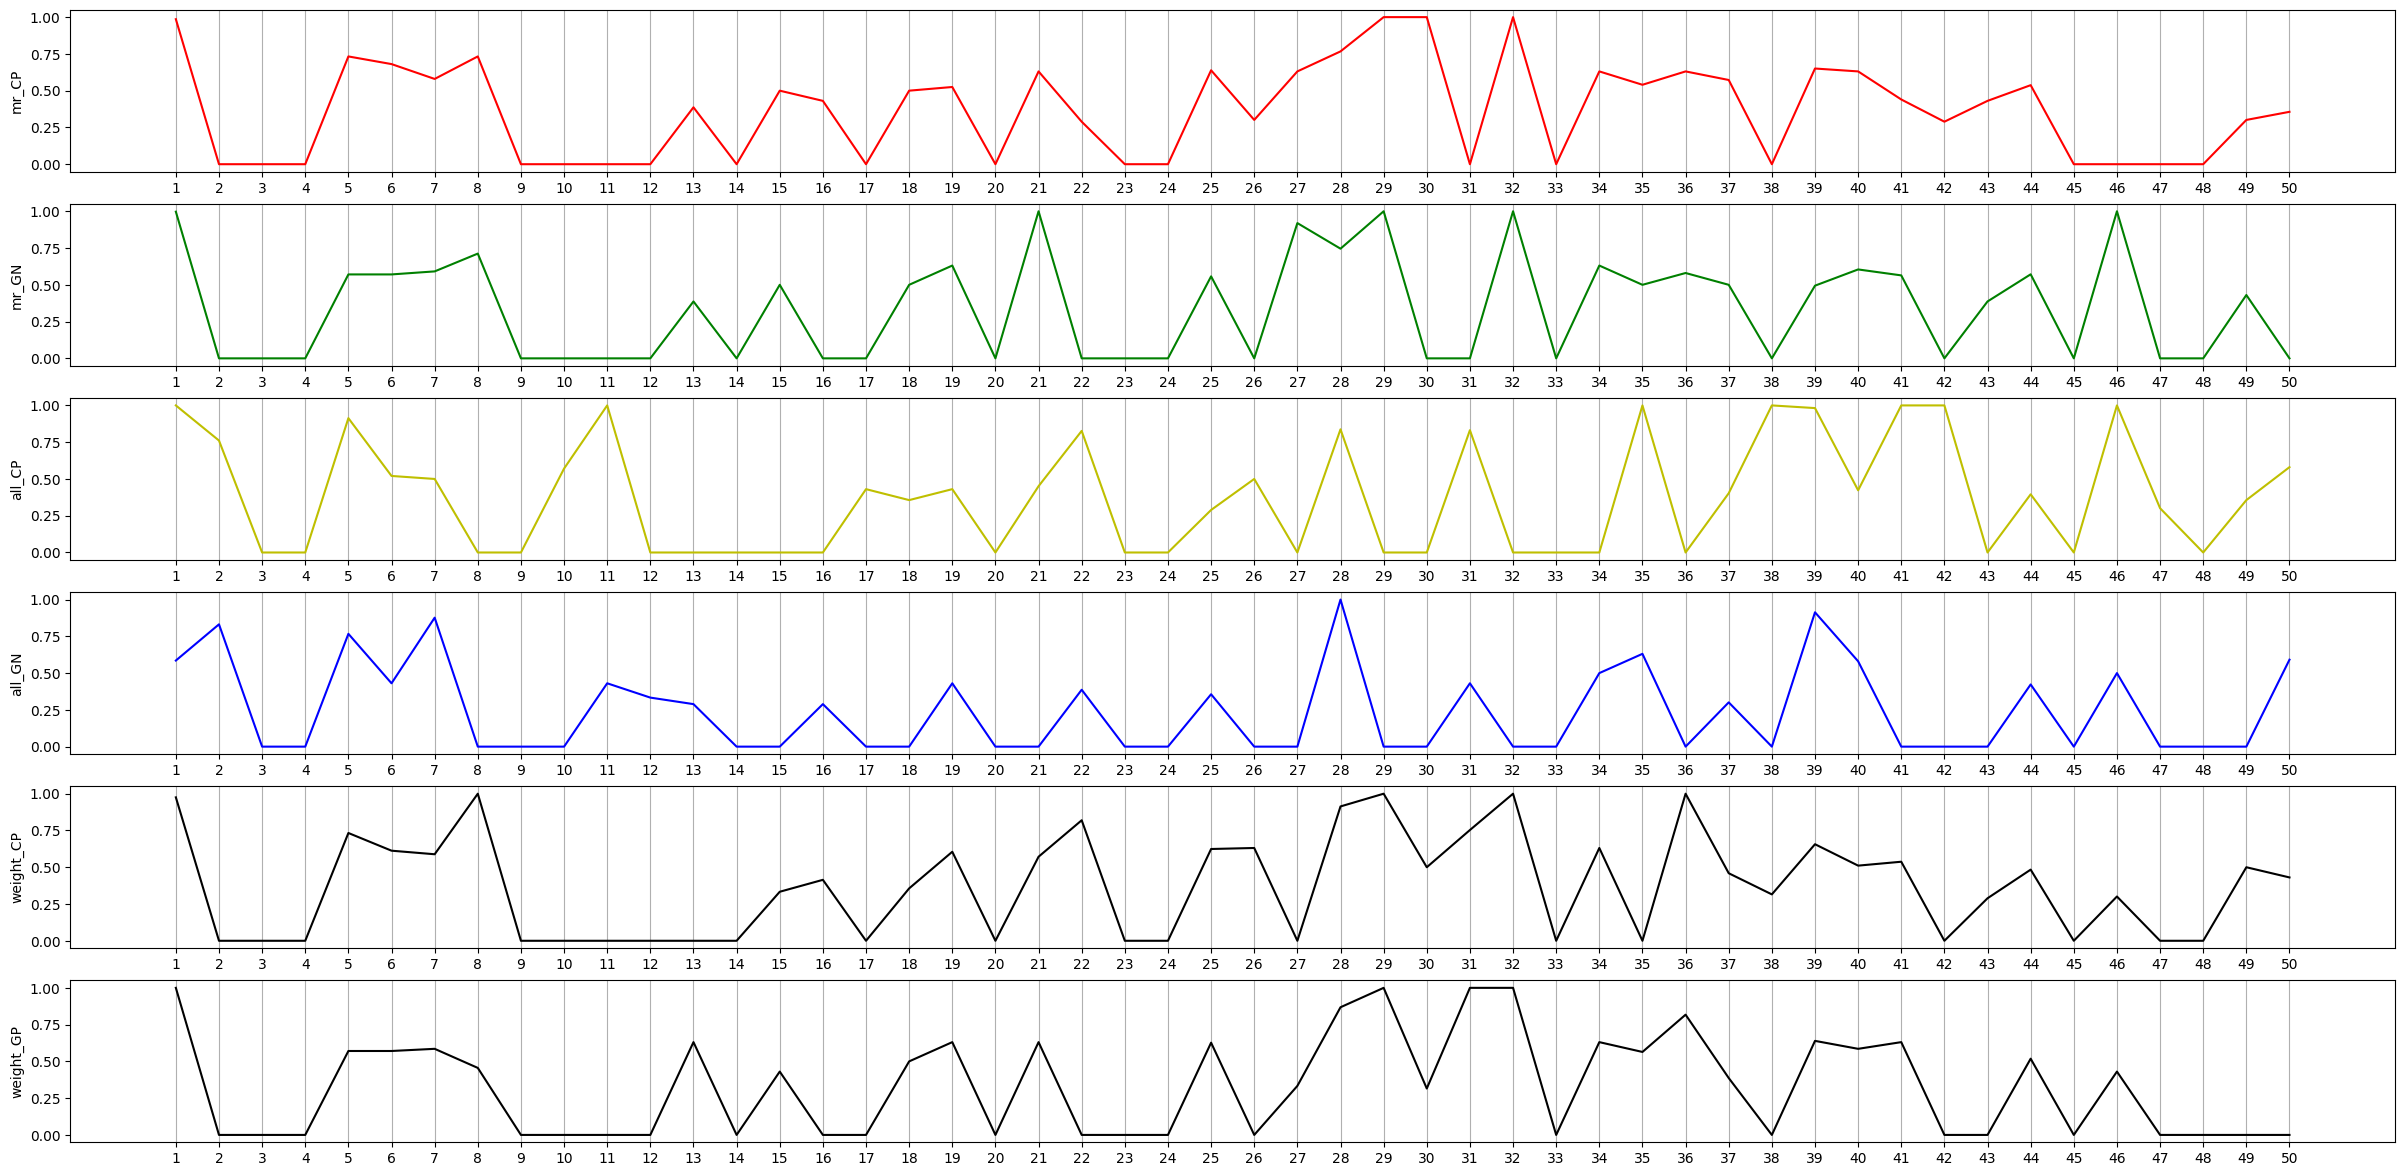

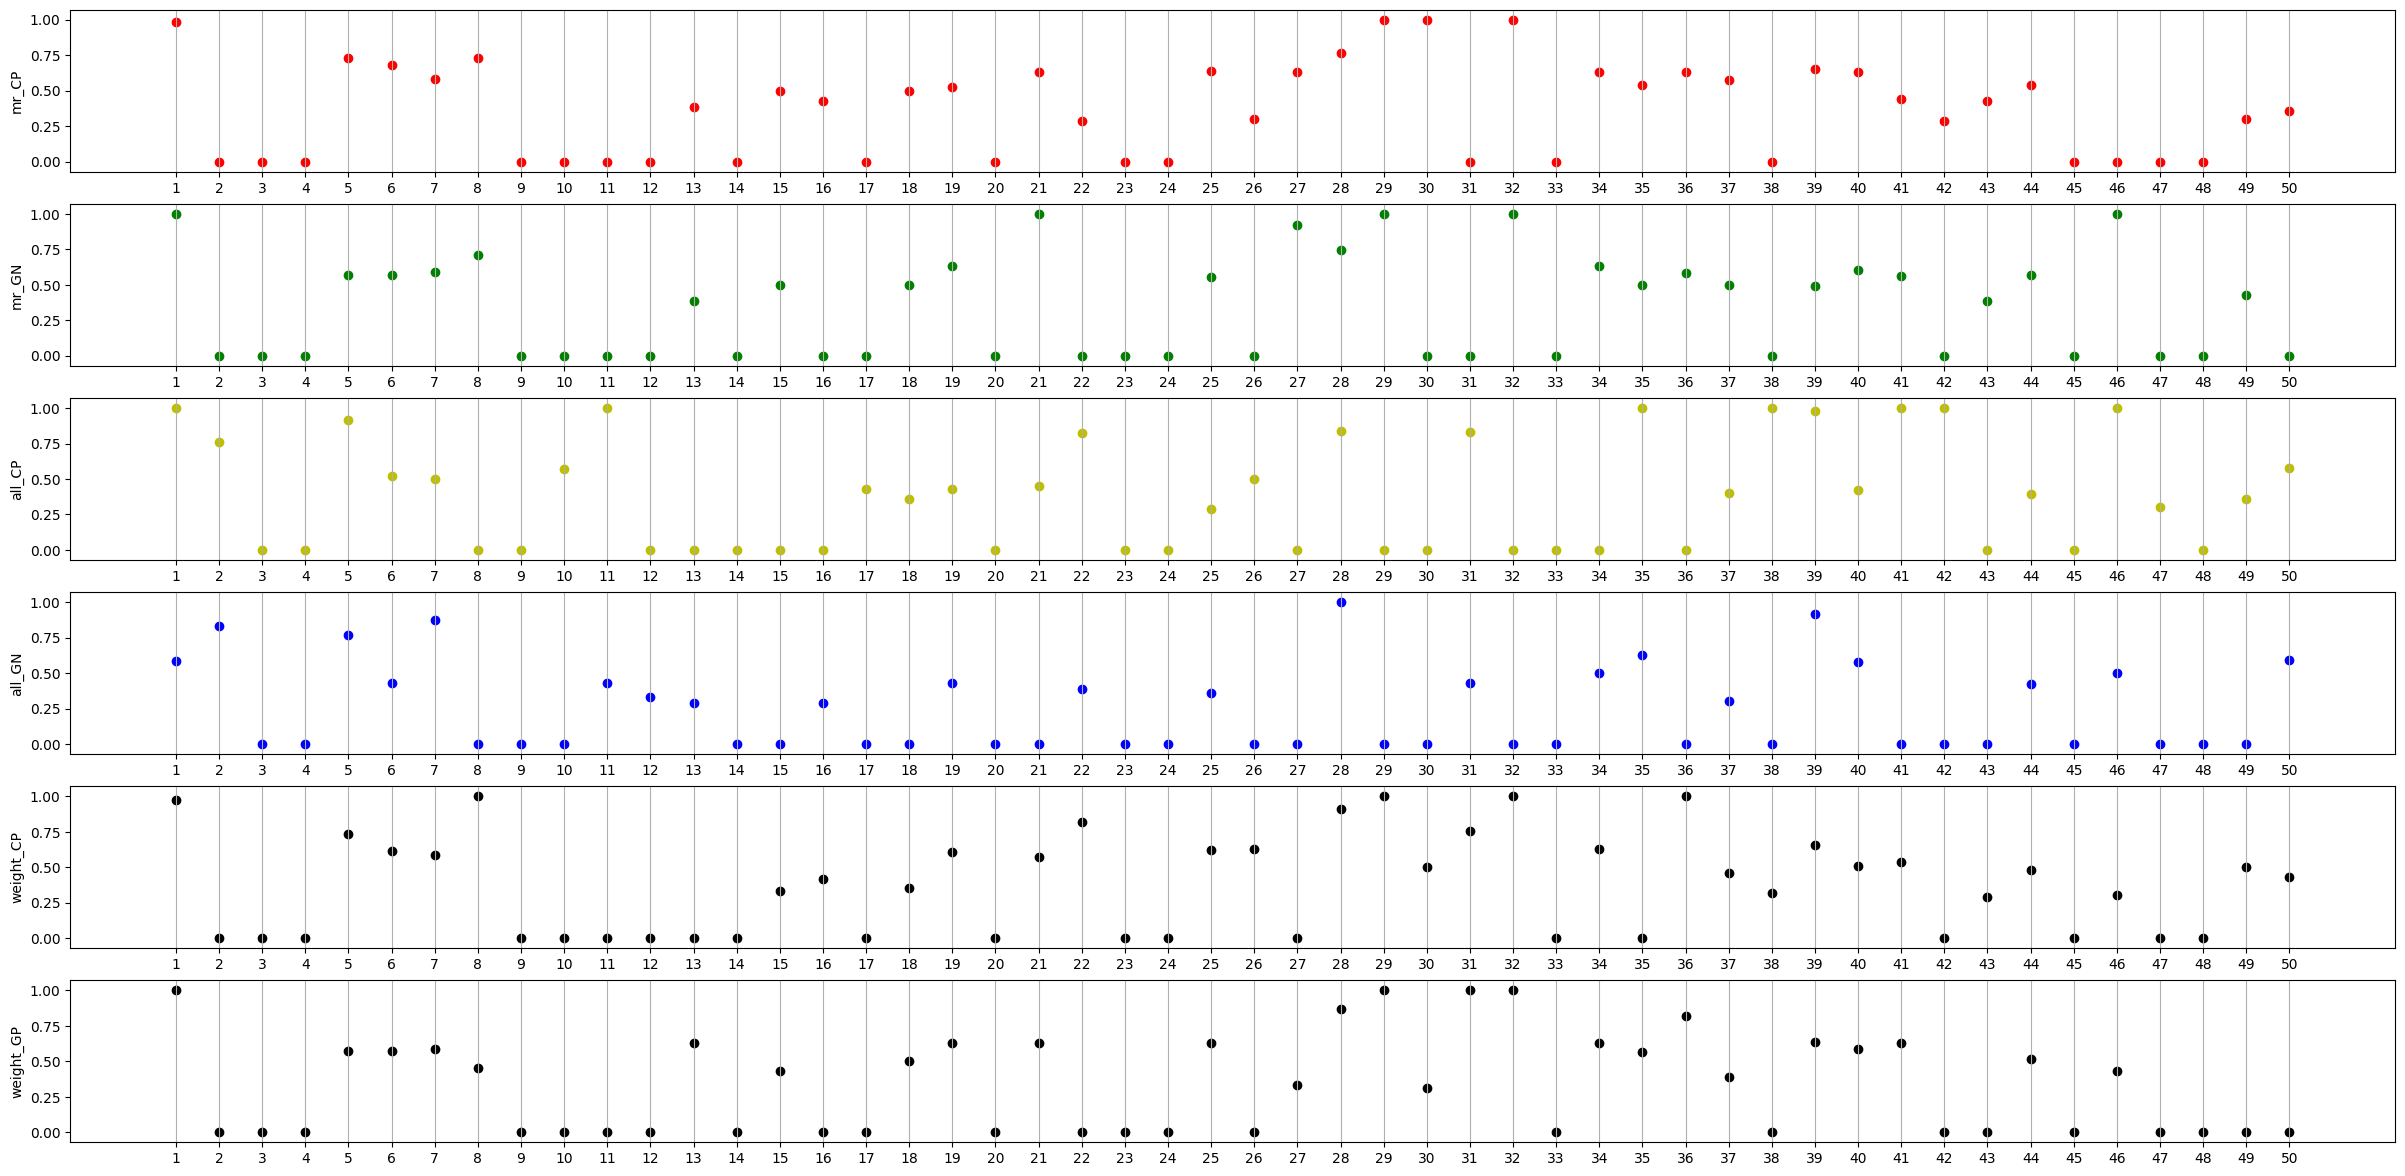

In [20]:
# plot of NDCG@10 for each researchers in several subplots
color = ['r','g','y','b','k','k']
y_label = ['mr_CP', 'mr_GN', 'all_CP', 'all_GN','weight_CP','weight_GP']
# plot
plt.figure(figsize=(30,15), dpi= 100)
for index,y_data in enumerate(ndcg4each_user):
    plt.subplot(6,1,index +1)
    # plot
    plt.plot(x_data, y_data, c=color[index])
    plt.ylabel(y_label[index])
    plt.xticks(x_data[::1])
    plt.grid(axis = 'x')
plt.show()  

# scatter
plt.figure(figsize=(30,15), dpi= 100)
for index,y_data in enumerate(ndcg4each_user):
    plt.subplot(6,1,index +1)
    plt.scatter(x_data, y_data, c=color[index])
    plt.ylabel(y_label[index])
    plt.xticks(x_data[::1])
    plt.grid(axis = 'x')
plt.show() 

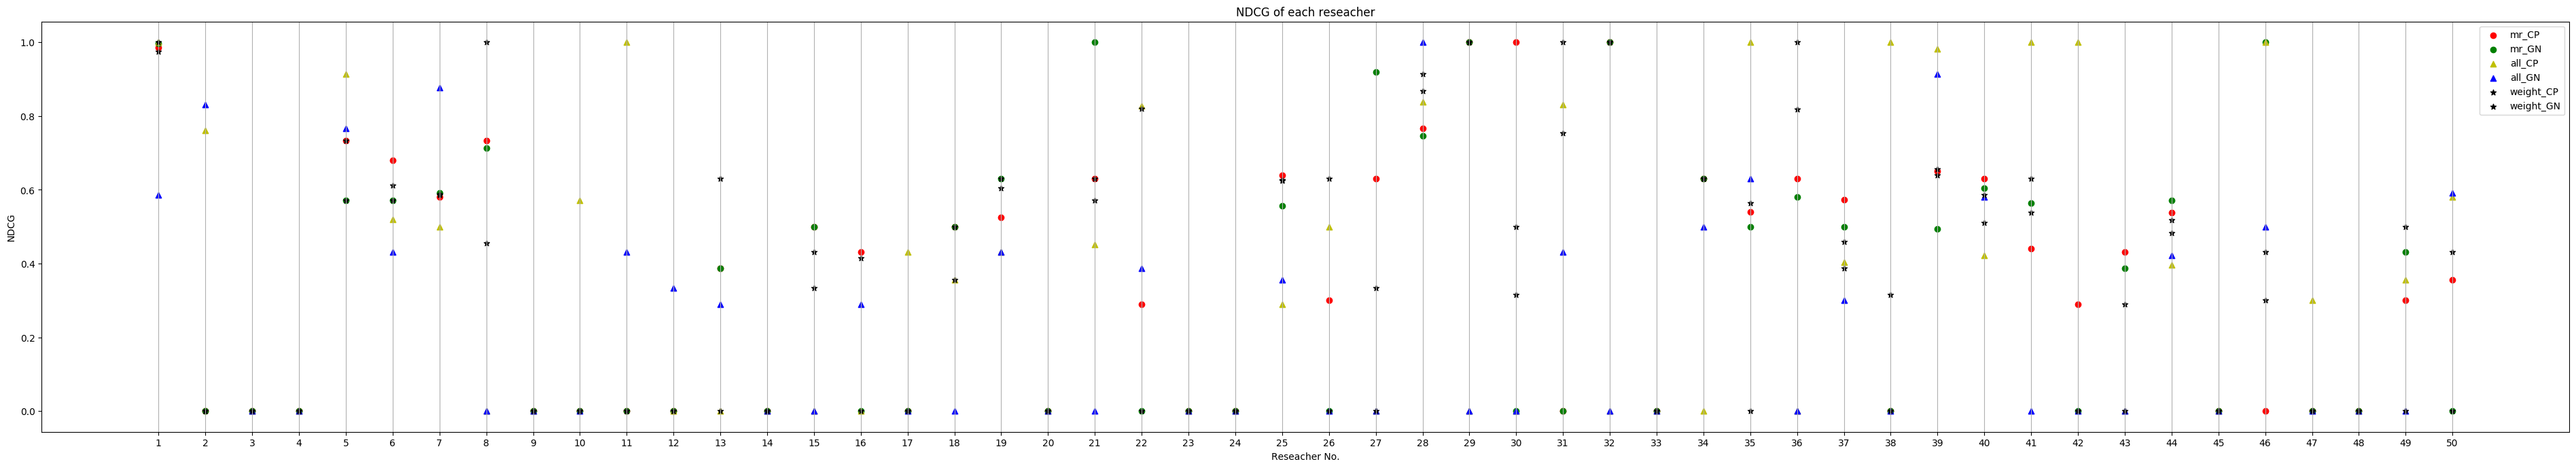

In [21]:
import matplotlib.pyplot as plt

# plot of NDCG@10 for each reseacher
x_data = list(range(1,51,1))
y1_data = ndcg4each_user[0]
y2_data = ndcg4each_user[1]
y3_data = ndcg4each_user[2]
y4_data = ndcg4each_user[3]
y5_data = ndcg4each_user[4]
y6_data = ndcg4each_user[5]

plt.figure(figsize=(48,8), dpi= 100)
l1 = plt.scatter(x_data, y1_data, c = 'r', marker = 'o', label = "mr_CP")
l2 = plt.scatter(x_data, y2_data, c = 'g', marker = 'o', label = "mr_GN")
l3 = plt.scatter(x_data, y3_data, c = 'y', marker = '^', label = "all_CP")
l4 = plt.scatter(x_data, y4_data, c = 'b', marker = '^', label = "all_GN")
l5 = plt.scatter(x_data, y5_data, c = 'k', marker = '*', label = "weight_CP")
l6 = plt.scatter(x_data, y6_data, c = 'k', marker = '*', label = "weight_GN")
plt.xlabel('Reseacher No.')
plt.ylabel('NDCG')
plt.xticks(x_data[::1])
plt.title('NDCG of each reseacher')
plt.grid(axis = 'x')
plt.legend()
plt.show()

In [ ]:
# plot of Precision@10 for each reseacher
x_data = list(range(1,51,1))
y1_data = ndcg4each_user[0]
y2_data = ndcg4each_user[1]
y3_data = ndcg4each_user[2]
y4_data = ndcg4each_user[3]
y5_data = ndcg4each_user[4]
y6_data = ndcg4each_user[5]

plt.figure(figsize=(48,8), dpi= 100)
l1 = plt.scatter(x_data, y1_data, c = 'r', marker = 'o', label = "mr_CP")
l2 = plt.scatter(x_data, y2_data, c = 'g', marker = 'o', label = "mr_GN")
l3 = plt.scatter(x_data, y3_data, c = 'y', marker = '^', label = "all_CP")
l4 = plt.scatter(x_data, y4_data, c = 'b', marker = '^', label = "all_GN")
l5 = plt.scatter(x_data, y5_data, c = 'k', marker = '*', label = "weight_CP")
l6 = plt.scatter(x_data, y6_data, c = 'k', marker = '*', label = "weight_GN")
plt.xlabel('Reseacher No.')
plt.ylabel('Precision@10')
plt.xticks(x_data[::1])
plt.title('Precision@10 of each reseacher')
plt.grid(axis = 'x')
plt.legend()
plt.show()

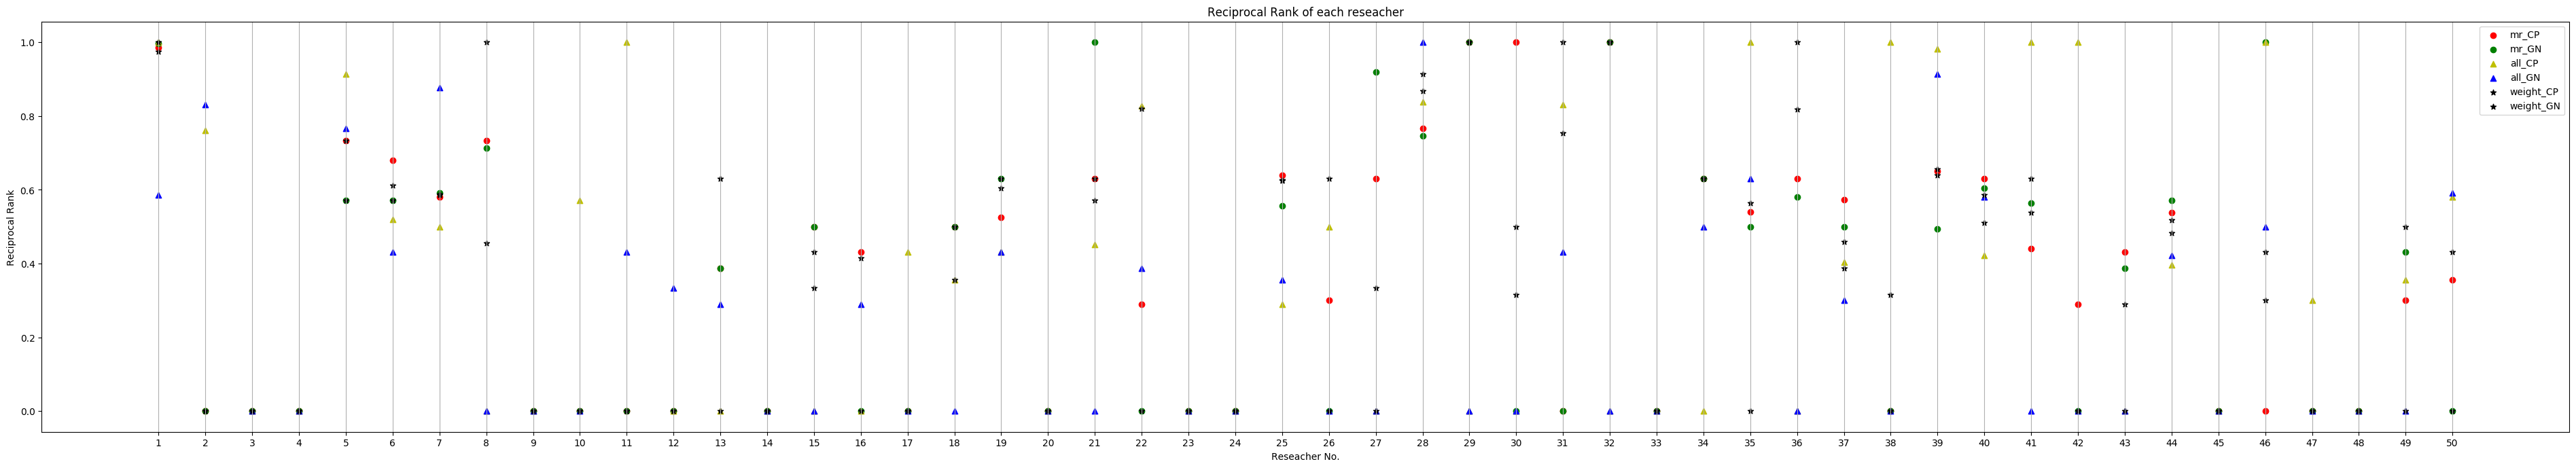

In [22]:
# plot of Reciprocal Rank for each reseacher
x_data = list(range(1,51,1))
y1_data = ndcg4each_user[0]
y2_data = ndcg4each_user[1]
y3_data = ndcg4each_user[2]
y4_data = ndcg4each_user[3]
y5_data = ndcg4each_user[4]
y6_data = ndcg4each_user[5]

plt.figure(figsize=(48,8), dpi= 100)
l1 = plt.scatter(x_data, y1_data, c = 'r', marker = 'o', label = "mr_CP")
l2 = plt.scatter(x_data, y2_data, c = 'g', marker = 'o', label = "mr_GN")
l3 = plt.scatter(x_data, y3_data, c = 'y', marker = '^', label = "all_CP")
l4 = plt.scatter(x_data, y4_data, c = 'b', marker = '^', label = "all_GN")
l5 = plt.scatter(x_data, y5_data, c = 'k', marker = '*', label = "weight_CP")
l6 = plt.scatter(x_data, y6_data, c = 'k', marker = '*', label = "weight_GN")
plt.xlabel('Reseacher No.')
plt.ylabel('Reciprocal Rank')
plt.xticks(x_data[::1])
plt.title('Reciprocal Rank of each reseacher')
plt.grid(axis = 'x')
plt.legend()
plt.show()